# Deterministic forecasting of the gold price using ARIMA method

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
# Get gold price df and set date as index
df_au = pd.read_csv("../data/AU.csv", index_col="date", parse_dates=True)

In [3]:
# Set charts theme
sns.set_theme(style="darkgrid", rc={"grid.alpha": 0.33})
plt.style.use("dark_background")

# Save chart as png function
def save_chart_as_png(filename: str) -> None:
    plt.savefig(
        f"../images/{filename}.png",
        format="png",
        dpi=300,
        orientation="landscape",
        bbox_inches="tight",
    )

## Preparing the time series to fit the ARIMA models

### Resample to weekly prices

In [4]:
# Resample to weekly prices (taking the mean of the week)
df_au = df_au.resample("W").mean()
df_au = df_au.asfreq("W")
# Front fill missing values
df_au.ffill(inplace=True)

### Split data into train and test

In [5]:
# Split the data into train and test sets based on date
split_date = pd.Timestamp("2022-01-01")
df_au_train = df_au.loc[df_au.index < split_date].copy()
df_au_test = df_au.loc[df_au.index >= split_date].copy()

In [6]:
# Check for missing values
print(df_au_train.isnull().sum())
print(df_au_test.isnull().sum())

price    0
dtype: int64
price    0
dtype: int64


### Check if the time series is stationary

<Axes: xlabel='date'>

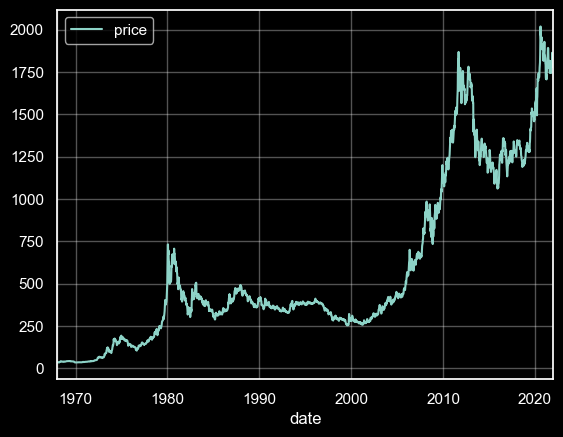

In [7]:
# Plot the df
df_au_train.plot()

The plot clearly shows an upward trend, indicating the series is not stationary. Let's confirm this with other methods.

#### Autocorrelation function (ACF) and partial autocorrelation function (PACF)

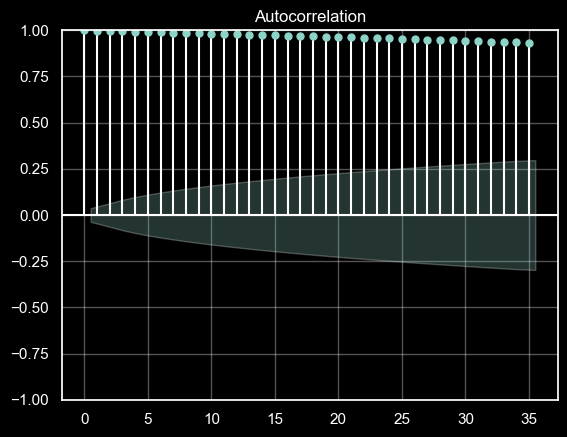

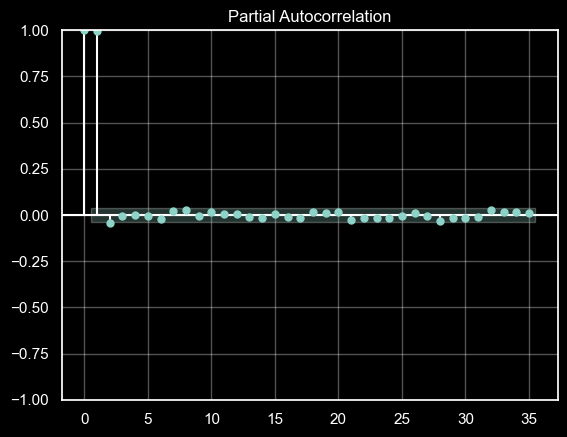

In [8]:
# Plot the acf and pacf
acf = plot_acf(df_au_train)
pacf = plot_pacf(df_au_train)

- The autocorrelation function (ACF) plot shows that the correlations decline slowly, indicating a strong and persistent correlation over time. This slow decay suggests that the time series data is non-stationary.
- The partial autocorrelation function (PACF) plot reveals that only the lag 1 value is significantly different from zero, indicating a strong correlation at lag 1 but not beyond. This pattern is typical of an autoregressive process.
- Together, these observations suggest that the time series data is non-stationary and shows a high degree of autocorrelation.

#### Augmented Dickey–Fuller (ADF) test

In [9]:
# Perform ADF test
adf_test  = adfuller(df_au_train)
print(f"p-value: {adf_test[1]}")

p-value: 0.9794340725378696


- The ADF test results in a p-value close to 1, which is significantly greater than the 0.05 threshold.
- A high p-value indicates that we fail to reject the null hypothesis of the ADF test, which states that the time series has a unit root (non-stationary)

### Transform time series into stationary using differencing

In [10]:
# Create diff from df
df_au_train_diff = df_au_train.diff().dropna()

### Check again for stationarity and determine ARIMA parameters

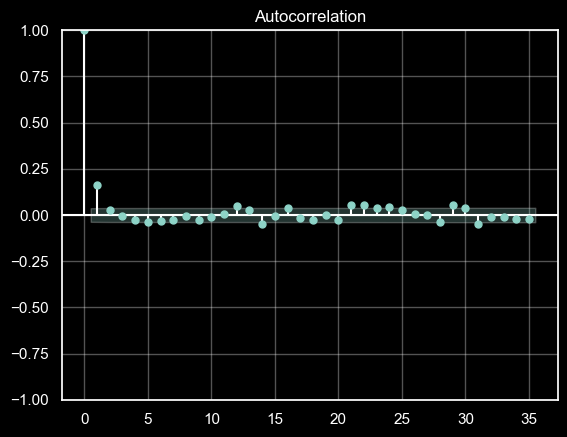

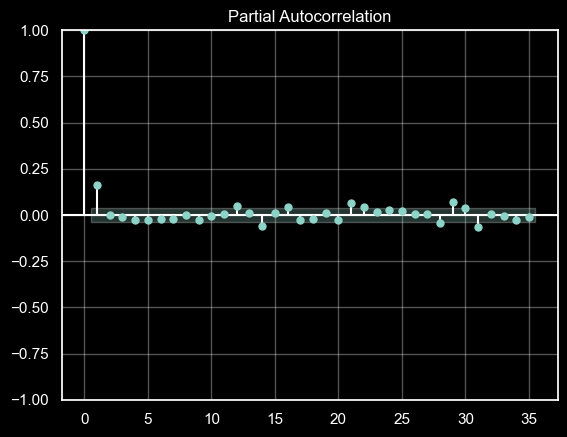

In [11]:
# Plot the acf and pacf
acf = plot_acf(df_au_train_diff)
pacf = plot_pacf(df_au_train_diff)

In [12]:
# Perform ADF test
adf_test  = adfuller(df_au_train_diff)
print(f"p-value: {adf_test[1]}")

p-value: 1.290886979016959e-13


- After differencing, we can conclude that the time series is stationary with "d" = 1.
- Based on the ACF and PACF plots, "q" is 1 and "p" is 1.
- Let's use the pmdarima module to obtain the "auto" parameters.

### Determine the ARIMA parameters using pmdarima

In [13]:
model_auto = pm.auto_arima(df_au_train, seasonal=True, m=52, trace=True, error_action="ignore", suppress_warnings=True, stepwise=True)
model_auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=23354.536, Time=51.39 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=23425.333, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=23353.656, Time=10.13 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=23355.862, Time=9.62 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=23427.917, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=23353.238, Time=0.10 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=23353.785, Time=5.11 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=23354.059, Time=14.09 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=23355.235, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=23355.237, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=23355.372, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=23357.230, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[52]             : AIC=23354.552, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[52] intercept
Total fit time: 91.691

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2817
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -11673.619
Date:                Fri, 21 Jun 2024   AIC                          23353.238
Time:                        20:24:42   BIC                          23371.068
Sample:                    01-07-1968   HQIC                         23359.672
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5249      0.295      1.780      0.075      -0.053       1.103
ar.L1          0.1611      0.008     20.416      0.000       0.146       0.177
sigma2       233.5481      1.972    118.432      0.000     229.683     237.413
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             42578.99
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               5.29   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Fit the ARIMA models

### Train the ARIMA models

#### Manual model

In [14]:
manual_model = ARIMA(df_au_train, order=(1, 1, 1))
manual_model_fit = manual_model.fit()
manual_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 2817
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11675.269
Date:                Fri, 21 Jun 2024   AIC                          23356.537
Time:                        20:24:43   BIC                          23374.367
Sample:                    01-07-1968   HQIC                         23362.971
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1755      0.063      2.793      0.005       0.052       0.299
ma.L1         -0.0134      0.064     -0.207      0.836      -0.140       0.113
sigma2       233.7392      2.049    114.056      0.000     229.723     237.756
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             42482.80
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               5.30   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Auto model

In [15]:
# Auto model is seasonal
auto_model = ARIMA(df_au_train, order=model_auto.order, seasonal_order=model_auto.seasonal_order)
auto_model_fit = auto_model.fit()
auto_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 2817
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -11675.276
Date:                Fri, 21 Jun 2024   AIC                          23354.552
Time:                        20:24:43   BIC                          23366.438
Sample:                    01-07-1968   HQIC                         23358.841
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1625      0.008     20.670      0.000       0.147       0.178
sigma2       233.8232      1.937    120.683      0.000     230.026     237.621
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             42593.01
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               5.30   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Check models residuals

#### Manual model

<Axes: title={'center': 'Density'}, ylabel='Density'>

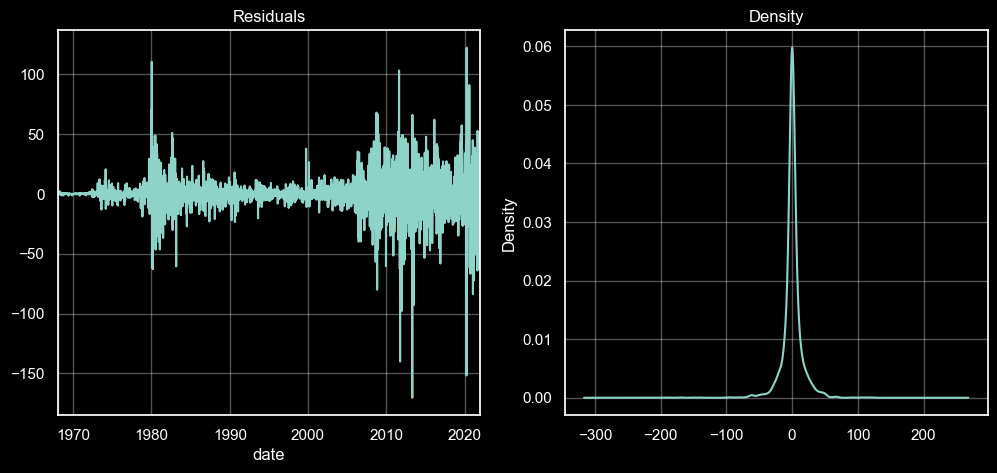

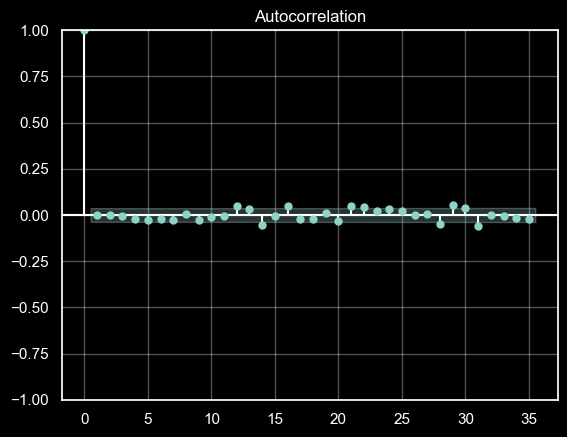

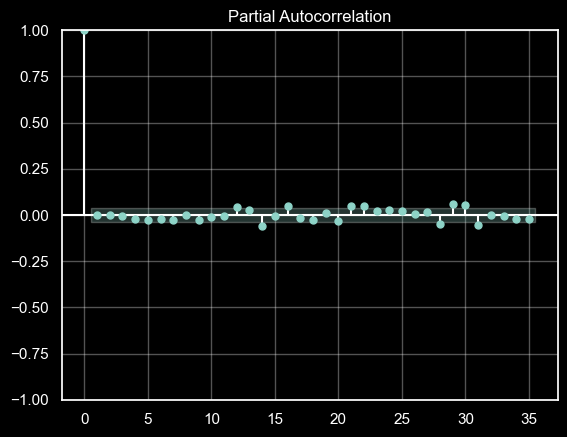

In [16]:
residuals = manual_model_fit.resid[1:]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(residuals)
plot_pacf(residuals)
residuals.plot(title="Residuals", ax=axes[0])
residuals.plot(title="Density", ax=axes[1], kind="kde")

#### Auto model

<Axes: title={'center': 'Density'}, ylabel='Density'>

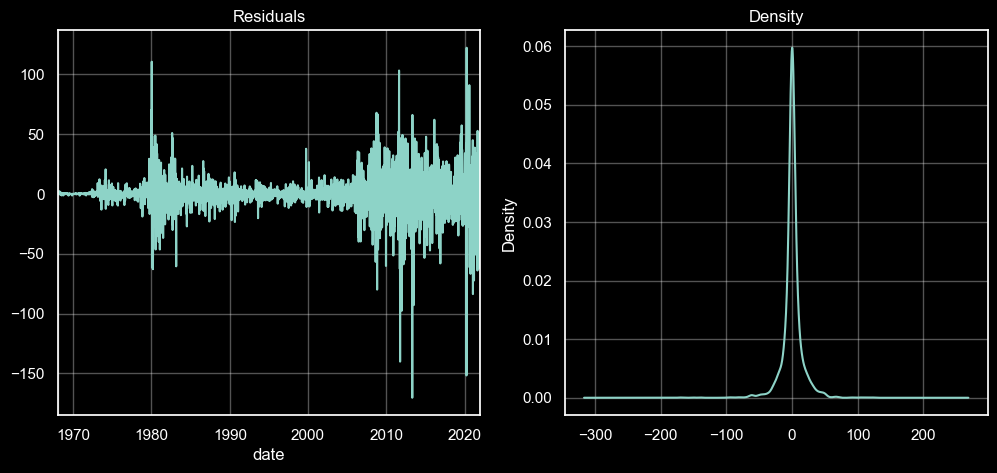

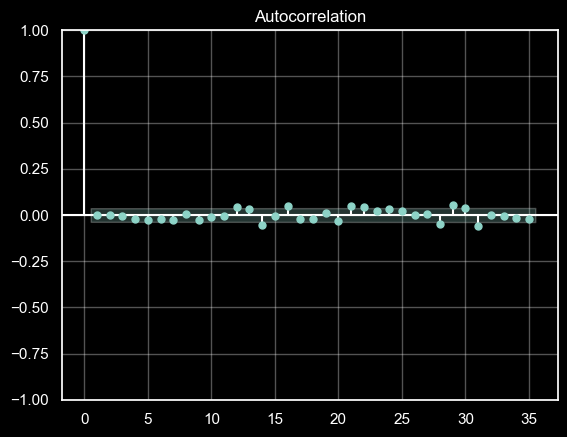

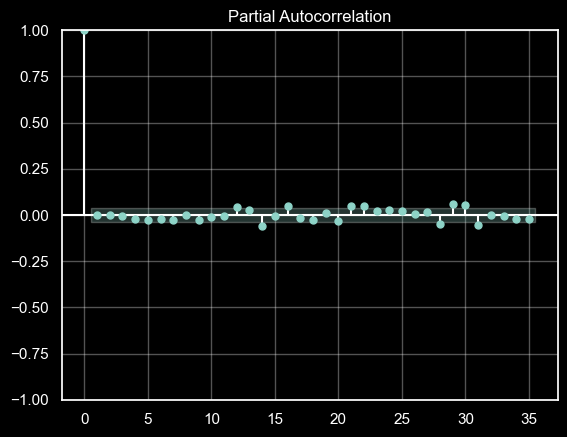

In [17]:
residuals = auto_model_fit.resid[1:]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(residuals)
plot_pacf(residuals)
residuals.plot(title="Residuals", ax=axes[0])
residuals.plot(title="Density", ax=axes[1], kind="kde")

- Residuals resemble white noise in both models.
- Their density is normally distributed.
- ACF and PACF plots show no significant spikes for both models.
- Therefore, the models appear to be well-fitted and meet the necessary diagnostic criteria.

### Forecast on the training data

In [18]:
# Get number of periods to forecast from test
n_forecast = len(df_au_test)

#### Manual model

In [19]:
# Get forecast values
manual_forecast = manual_model_fit.get_forecast(steps=n_forecast)
manual_forecast_values = manual_forecast.predicted_mean
manual_conf_int = manual_forecast.conf_int()

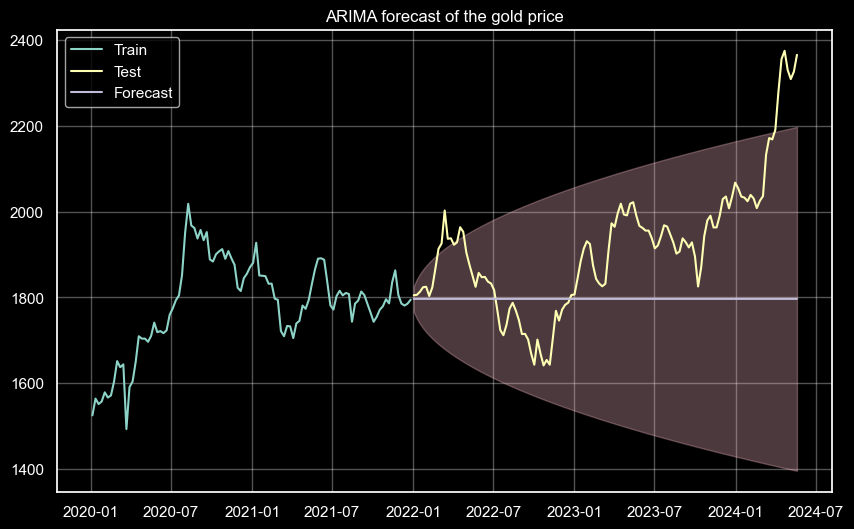

In [20]:
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(df_au_train.loc["2020-01-01":].index, df_au_train.loc["2020-01-01":].values, label="Train")

# Plot the test data
plt.plot(df_au_test.loc["2020-01-01":].index, df_au_test.loc["2020-01-01":].values, label="Test")

# Plot the forecast data
plt.plot(df_au_test.loc["2020-01-01":].index, manual_forecast_values, label="Forecast")

# Fill the confidence interval
plt.fill_between(df_au_test.loc["2020-01-01":].index, manual_conf_int.iloc[:, 0], manual_conf_int.iloc[:, 1], color="pink", alpha=0.3)

plt.title("ARIMA forecast of the gold price")
plt.xlabel("")
plt.ylabel("")
plt.legend(loc="upper left")

#### Auto model

In [21]:
# Get forecast values
auto_forecast = auto_model_fit.get_forecast(steps=n_forecast)
auto_forecast_values = auto_forecast.predicted_mean
auto_conf_int = auto_forecast.conf_int()

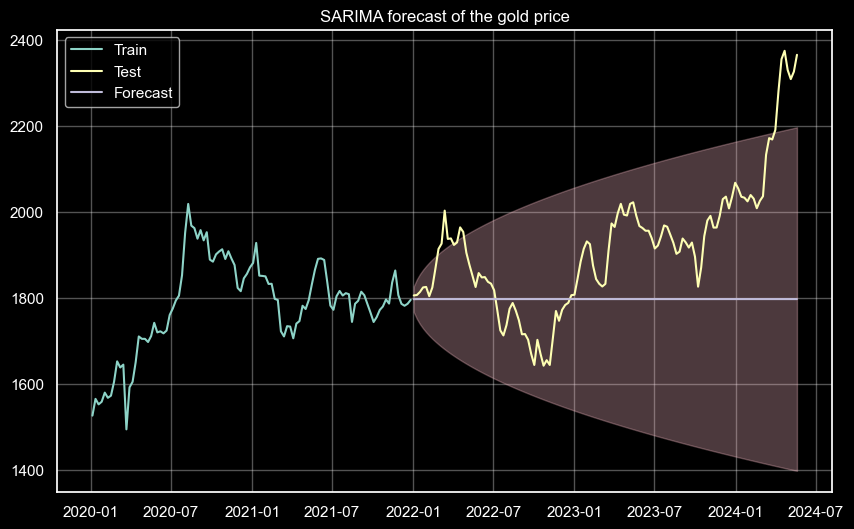

In [22]:
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(df_au_train.loc["2020-01-01":].index, df_au_train.loc["2020-01-01":].values, label="Train")

# Plot the test data
plt.plot(df_au_test.loc["2020-01-01":].index, df_au_test.loc["2020-01-01":].values, label="Test")

# Plot the forecast data
plt.plot(df_au_test.loc["2020-01-01":].index, auto_forecast_values, label="Forecast")

# Fill the confidence interval
plt.fill_between(df_au_test.loc["2020-01-01":].index, auto_conf_int.iloc[:, 0], auto_conf_int.iloc[:, 1], color="pink", alpha=0.3)

plt.title("SARIMA forecast of the gold price")
plt.xlabel("")
plt.ylabel("")
plt.legend(loc="upper left")

### Evaluate both models

#### Manual model

In [23]:
# Evaluate model
mae = mean_absolute_error(df_au_test, manual_forecast_values)
rmse = np.sqrt(mean_squared_error(df_au_test, manual_forecast_values))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 150.4699452987774
RMSE: 195.79931706861416


#### Auto model

In [24]:
# Evaluate model
mae = mean_absolute_error(df_au_test, auto_forecast_values)
rmse = np.sqrt(mean_squared_error(df_au_test, auto_forecast_values))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 150.49174095743774
RMSE: 195.82168111672118


**Unfortunately, neither the manual nor the auto models provided acceptable results. We need to try a different strategy.**

### Fine tune a model

In [25]:
# Fit tuned model
tuned_model = ARIMA(df_au_train, order=(3, 1, 0), seasonal_order=(0, 1, 1, 52))
tuned_model_fit = tuned_model.fit()
tuned_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                 2817
Model:             ARIMA(3, 1, 0)x(0, 1, [1], 52)   Log Likelihood              -11560.405
Date:                            Fri, 21 Jun 2024   AIC                          23130.810
Time:                                    20:27:32   BIC                          23160.432
Sample:                                01-07-1968   HQIC                         23141.509
                                     - 12-26-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1568      0.009     18.371      0.000       0.140       0.173
ar.L2          0.0040      0.011      0.370      0.711      -0.017       0.025
ar.L3         -0.0103      0.010     -1.007      0.314      -0.030       0.010
ma.S.L52      -0.9619      0.008   -118.628      0.000      -0.978      -0.946
sigma2       239.5095      2.222    107.778      0.000     235.154     243.865
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             37092.71
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               5.33   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
# Get forecast values
tuned_forecast = tuned_model_fit.get_forecast(steps=n_forecast)
tuned_forecast_values = tuned_forecast.predicted_mean
tuned_conf_int = tuned_forecast.conf_int()

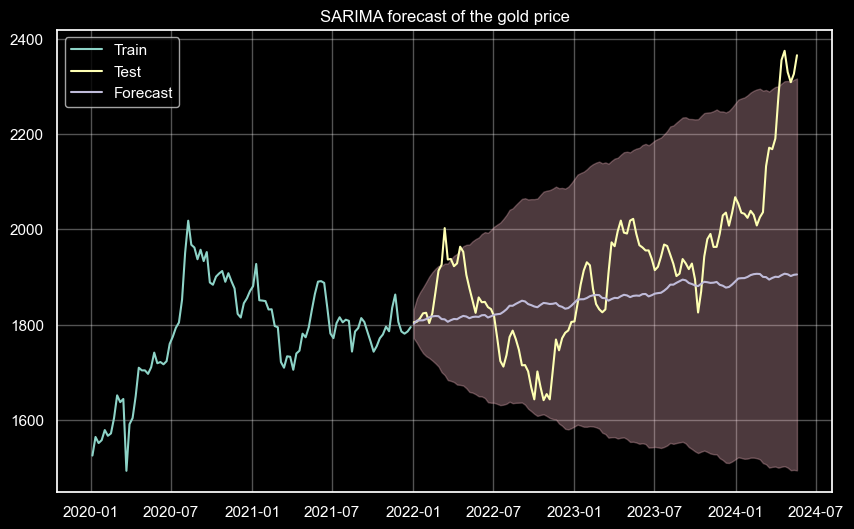

In [27]:
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(df_au_train.loc["2020-01-01":].index, df_au_train.loc["2020-01-01":].values, label="Train")

# Plot the test data
plt.plot(df_au_test.loc["2020-01-01":].index, df_au_test.loc["2020-01-01":].values, label="Test")

# Plot the forecast data
plt.plot(df_au_test.loc["2020-01-01":].index, tuned_forecast_values, label="Forecast")

# Fill the confidence interval
plt.fill_between(df_au_test.loc["2020-01-01":].index, tuned_conf_int.iloc[:, 0], tuned_conf_int.iloc[:, 1], color="pink", alpha=0.3)

plt.title("SARIMA forecast of the gold price")
plt.xlabel("")
plt.ylabel("")
plt.legend(loc="upper left")

In [28]:
# Evaluate model
mae = mean_absolute_error(df_au_test, tuned_forecast_values)
rmse = np.sqrt(mean_squared_error(df_au_test, tuned_forecast_values))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 110.71724624248195
RMSE: 148.3907197652151


**This model has provided acceptable results. Therefore it'll be used for the forecast.**

## The forecast

In [29]:
# Fit model
model = ARIMA(df_au, order=(3, 1, 0), seasonal_order=(0, 1, 1, 52))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                 2942
Model:             ARIMA(3, 1, 0)x(0, 1, [1], 52)   Log Likelihood              -12249.900
Date:                            Fri, 21 Jun 2024   AIC                          24509.800
Time:                                    20:30:34   BIC                          24539.644
Sample:                                01-07-1968   HQIC                         24520.556
                                     - 05-19-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1864      0.009     21.745      0.000       0.170       0.203
ar.L2         -0.0208      0.011     -1.883      0.060      -0.043       0.001
ar.L3         -0.0130      0.010     -1.259      0.208      -0.033       0.007
ma.S.L52      -0.9537      0.007   -138.140      0.000      -0.967      -0.940
sigma2       270.2412      2.604    103.799      0.000     265.138     275.344
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             26405.21
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               6.20   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
# Get number of periods (weeks) to forecast
n_forecast = 26

In [31]:
# Get forecast values
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()
forecast_index = pd.date_range(start=df_au.index[-1], periods=n_forecast + 1, freq="W")[1:]

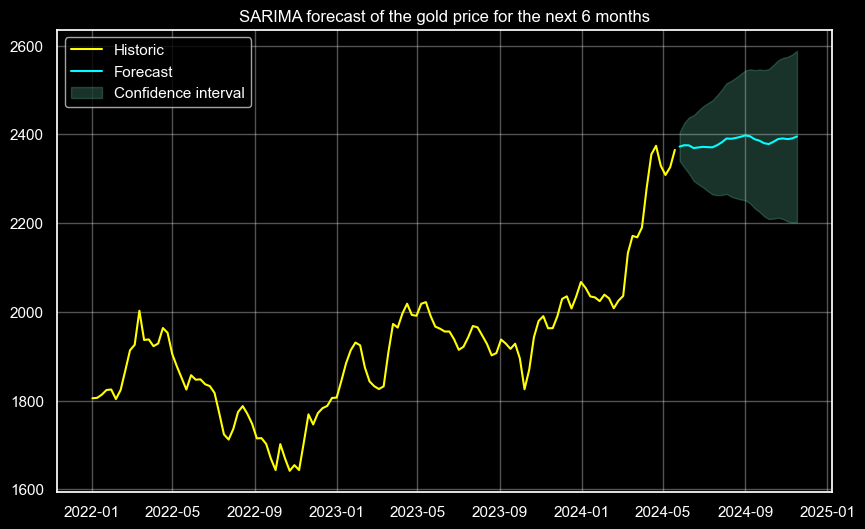

In [32]:
plt.figure(figsize=(10, 6))

# Plot the original data
sns.lineplot(x=df_au.loc["2022-01-01":].index, y=df_au.loc["2022-01-01":]["price"], label="Historic", color="yellow")

# Plot the forecast data
sns.lineplot(x=forecast_index, y=forecast_values, label="Forecast", color="aqua")

# Fill the confidence interval
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], label="Confidence interval", color="aquamarine", alpha=0.2)

plt.title("SARIMA forecast of the gold price for the next 6 months")
plt.xlabel("")
plt.ylabel("")
plt.legend(loc="upper left")

save_chart_as_png("7.1_AU_ARIMA")

**The forecast indicates that gold prices will consistently rise over the next six months.**